In this project, we aim to calibrate the Hull-White one-factor model using market data, specifically focusing on Black-implied swaption volatilities. This process involves estimating the model's parameters so that the model's output matches observed market prices of swaptions. We start by pricing swaptions using the Jamshidian trick, which allows us to decompose the swaption pricing problem into a series of simpler steps. By applying this method, we can efficiently calculate the swaption price under the Hull-White framework, ensuring accurate calibration to market data

### Market data

#### Zero coupon curve
This function builds a zero-coupon (ZC) curve by bootstrapping from market par rates (Euribor, swaps, etc.). For short maturities (≤1 year), it directly computes discount factors using simple interest. For longer maturities, it uses previously calculated ZC values to back out the new discount factor, accounting for coupon payments.

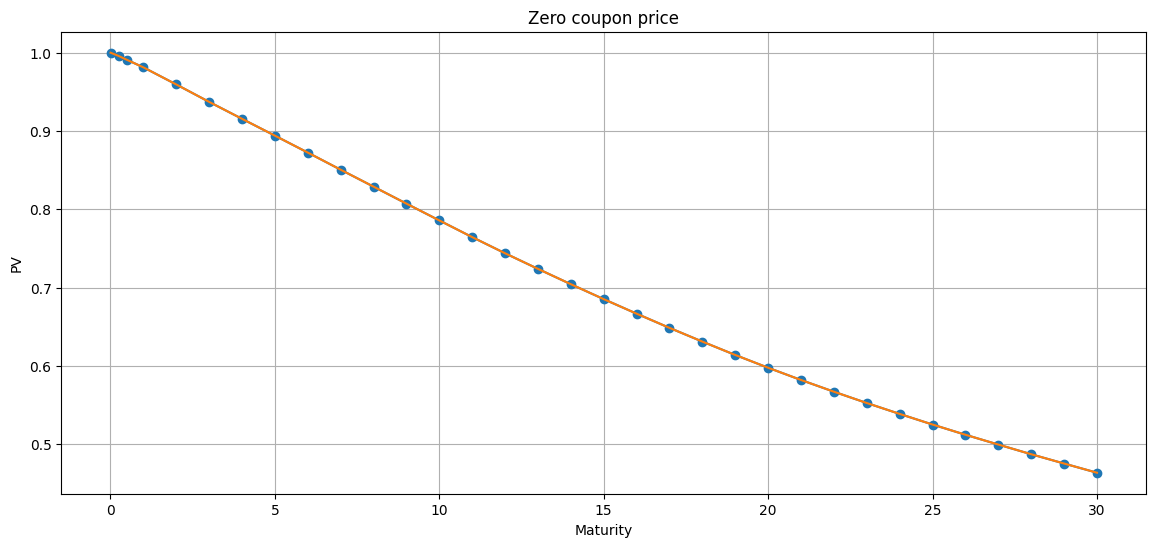

In [6]:
data = {
    "Maturity": [
        0.003968, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
        8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0,
        18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0,
        28.0, 29.0, 30.0
    ],
    "Type": [
        "Overnight", "Euribor", "Euribor", "Euribor",
        "Swap", "Swap", "Swap", "Swap", "Swap", "Swap",
        "Swap", "Swap", "Swap", "Swap", "Swap", "Swap",
        "Swap", "Swap", "Swap", "Swap", "Swap", "Swap",
        "Swap", "Swap", "Swap", "Swap", "Swap", "Swap",
        "Swap", "Swap", "Swap", "Swap", "Swap"
    ],
    "Rate": [
        0.01430, 0.01690, 0.01840, 0.01908, 0.02091, 0.02184,
        0.02227, 0.02261, 0.02295, 0.02332, 0.02364, 0.02396,
        0.02426, 0.02455, 0.02478, 0.02496, 0.02513, 0.02528,
        0.02541, 0.02553, 0.02563, 0.02572, 0.02578, 0.02582,
        0.02584, 0.02585, 0.02585, 0.02585, 0.02584, 0.02582,
        0.02581, 0.02579, 0.02578
    ]
}

def extractZCCurve(maturities, rates):
    ZC = []
    for i in range(len(maturities)):
        if maturities[i] <=1:
            ZCvalue = 1 / (1 +  maturities[i] *  rates[i])
            ZC.append(ZCvalue)
        else: 
            ZCvalue = (1.0 - rates[i] * sum(ZC[3:i])) / (1 + rates[i])
            ZC.append(ZCvalue)

    return np.array(ZC)

data['ZC_PRICE'] = extractZCCurve(data['Maturity'],data['Rate'])
zc_data = pd.DataFrame(data)
log_P_interp = interp1d(zc_data['Maturity'], np.log(zc_data['ZC_PRICE']), kind='cubic', fill_value='extrapolate')
zc_curve_interp = interp1d(zc_data['Maturity'],zc_data['ZC_PRICE'], kind='cubic', fill_value='extrapolate')


fig = plt.figure(figsize=(14, 6))
# Create the figure
ax1 = fig.add_subplot(1, 1, 1)
zc_interp = [zc_curve_interp(t) for t in zc_data['Maturity'].values]
ax1.plot(zc_data['Maturity'],zc_data['ZC_PRICE'] , marker='o', label ="ZC price")
ax1.plot(zc_data['Maturity'], zc_interp, label ="Yiel curve interpolate")
ax1.set_title('Zero coupon price')
ax1.set_xlabel('Maturity')
ax1.set_ylabel('PV')
ax1.grid(True)

#### Black’s implied volatilities (in %) of EUR ATM swaptions 
Black’s implied volatilities (in %) of EUR ATM swaptions on August 30, 2013.
Maturities are 1,2,3,4,5,7,10 years, swaps lengths from 1 to 10 years:

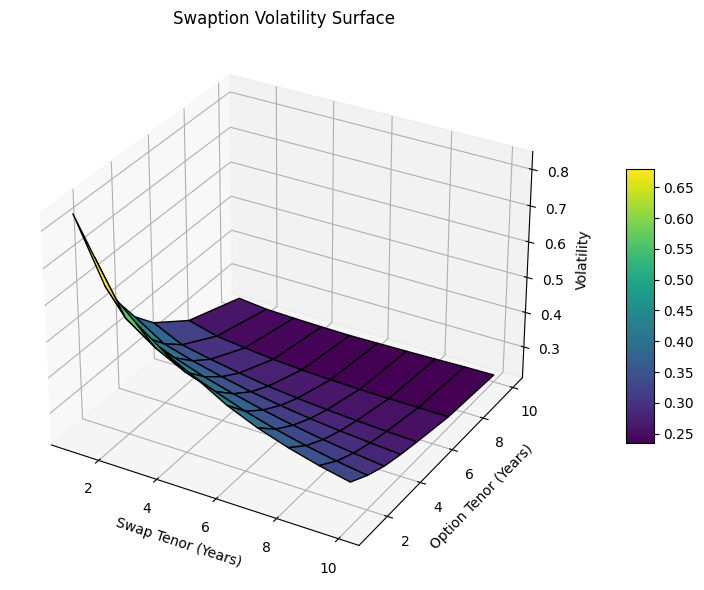

In [13]:
option_tenors = [1, 2, 3, 4, 5, 7, 10]
swap_tenors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

vol_matrix = np.array([
    [0.8356, 0.6660, 0.5910, 0.5300, 0.4882, 0.4402, 0.4042, 0.3761, 0.3534, 0.3353],
    [0.6795, 0.5370, 0.4789, 0.4370, 0.4080, 0.3786, 0.3548, 0.3353, 0.3192, 0.3065],
    [0.5212, 0.4420, 0.4085, 0.3801, 0.3572, 0.3372, 0.3203, 0.3062, 0.2948, 0.2853],
    [0.4326, 0.3803, 0.3561, 0.3359, 0.3186, 0.3052, 0.2938, 0.2851, 0.2778, 0.2716],
    [0.3737, 0.3345, 0.3175, 0.3029, 0.2903, 0.2811, 0.2741, 0.2687, 0.2646, 0.2609],
    [0.2964, 0.2744, 0.2644, 0.2560, 0.2499, 0.2463, 0.2437, 0.2424, 0.2423, 0.2417],
    [0.2376, 0.2286, 0.2258, 0.2239, 0.2227, 0.2239, 0.2252, 0.2269, 0.2290, 0.2301],
]) 

vol_df = pd.DataFrame(vol_matrix, index=option_tenors, columns=swap_tenors)

 

X, Y = np.meshgrid(swap_tenors, option_tenors)
Z = vol_matrix
fig = plt.figure(figsize=(14, 6))
ax2 = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax2.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')
ax2.set_title('Swaption Volatility Surface')
ax2.set_xlabel('Swap Tenor (Years)')
ax2.set_ylabel('Option Tenor (Years)')
ax2.set_zlabel('Volatility')
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


### Fit initial term structure

Le terme $\theta(t)$ est choisi pour que le modèle reproduise la courbe des taux zéro-coupon observée. Il est donné par :

$$
\theta(t) = \frac{d f(0,t)}{dt} + \alpha f(0,t) + \frac{\sigma^2}{2\alpha} \left(1 - e^{-2\alpha t} \right)
$$

où :
- $f(0,t) = -\frac{d}{dt} \ln P(0,t)$ est le taux instantané forward,
- $P(0,t)$ est le prix d’une obligation zéro-coupon à l’instant $0$ avec maturité $t$.



In [14]:
def forward_rate(t):
    return -derivative(log_P_interp, t, dx=1e-5)

def make_theta(kappa, sigma):
    def theta(t):
        fwd = forward_rate(t)
        dfwd_dt = derivative(forward_rate, t, dx=1e-5)
        correction = (sigma**2) / (2 * kappa) * (1 - np.exp(-2 * kappa * t))
        return dfwd_dt + kappa * fwd + correction
    return theta

### Option on zero coupon

Formulas from the Hull-White model for a European option on a zero-coupon bond.

#### Zero-coupon bond price

The price of a zero-coupon bond at time \( t \), maturing at \( T \), in the Hull-White model is:

$$
P(t, T) = \exp\left( -A(T, t) - B(T, t) \cdot r(t) \right)
$$

with:

$$
B(T, t) = \frac{1 - e^{-\kappa (T - t)}}{\kappa}
$$

and

$$
A(T, t) = \ln\left( \frac{P(0, T)}{P(0, t)} \right) + B(T, t) \cdot f(0, t) - \frac{\sigma^2}{2 \kappa^2} \left[ T - t + \frac{2}{\kappa} e^{-\kappa (T - t)} - \frac{1}{2\kappa} e^{-2\kappa (T - t)} - \frac{3}{2\kappa} \right]
$$

where \( f(0, t) \) is the instantaneous forward rate at time \( t \).



#### European option on a zero-coupon bond

The price of a European call option at time \( t \) with maturity \( T \), strike \( K \), on a zero-coupon bond maturing at \( S \) is given by:

$$
\text{Call}(t) = P(t, S) \cdot N(d_1) - K \cdot N(d_2)
$$

with:

$$
d_1 = \frac{\ln\left( \frac{P(T, S)}{K} \right) + \frac{1}{2} \sigma_p^2}{\sigma_p}
\quad ; \quad
d_2 = d_1 - \sigma_p
$$

and the adjusted volatility:

$$
\sigma_p = \sigma \cdot B(S, T) \cdot \sqrt{ \frac{1 - e^{-2\kappa T} }{2\kappa} }
$$


In [15]:
def B(T, t, kappa):
    return (1 - np.exp(-kappa * (T - t))) / kappa

def A(T, t, kappa, sigma):
    BtT = B(T, t, kappa)
    term1 = (sigma ** 2) / (2 * kappa ** 2) * (T - t + (2 / kappa) * np.exp(-kappa * (T - t)) - (1 / (2 * kappa)) * np.exp(-2 * kappa * (T - t)) - (3 / (2 * kappa)))
    P0T = np.exp(log_P_interp(T))
    P0t = np.exp(log_P_interp(t))
    return np.log(P0T / P0t) + BtT * forward_rate(t) - term1

def hw_zcb_option_price(T, S, K, sigma, kappa, r_t):
    B_TS = B(S, T, kappa)
    A_TS = A(S, T, kappa, sigma)
    P_TS = np.exp(-A_TS - B_TS * r_t)
    sigma_p = sigma * np.sqrt((1 - np.exp(-2 * kappa * T)) / (2 * kappa)) * B(S, T, kappa)
    d1 = (np.log(1 / K) + 0.5 * sigma_p ** 2) / sigma_p
    d2 = d1 - sigma_p
    return P_TS * norm.cdf(d1) - K * norm.cdf(d2)

### Swpation pricing


Let $P(T_{i}, T_{j}, r(t))$ be the price at time $t$ of a zero-coupon bond paying 1 at $T_j$, as seen from $T_i$, under a short-rate model.

We consider a **receiver swaption** with maturity $T_m$, which gives the right to enter into a fixed-for-floating interest rate swap (receiving fixed rate $k$) over the period $[T_m, T_n]$. Its value is:

$$
\text{Swaption} = \max\left( \text{Swap Value}(T_m),\ 0 \right)
$$

The value of the swap at time $T_m$ is:

$$
\text{Swap}(T_m) = \sum_{i=m+1}^{n} k \Delta_i P(T_m, T_i) + P(T_m, T_n) - 1
$$

We group the cash flows:

$$
= \sum_{i=m+1}^{n} C_i P(T_m, T_i) - 1
\quad \text{where } C_i = k \Delta_i,\ \text{and } C_n = k \Delta_n + 1
$$

The price of the swaption then becomes:

$$
\text{Swaption}(T_m) = \max\left( \sum_{i=m+1}^{n} C_i P(T_m, T_i) - 1,\ 0 \right)
$$

The price of a zero-coupon bond is a decreasing function of $r$. Therefore, by the **Jamshidian trick**, there exists a rate $r^*$ such that:

$$
\sum_{i=m+1}^{n} C_i P(T_m, T_i, r^*) = 1
$$

Thus:

$$
\text{Swaption}(T_m) = \max\left( \sum_{i=m+1}^{n} C_i \left[ P(T_m, T_i, r) - P(T_m, T_i, r^*) \right],\ 0 \right)
$$

$$
= \sum_{i=m+1}^{n} C_i \max\left( P(T_m, T_i, r) - P(T_m, T_i, r^*),\ 0 \right)
$$

Define:

$$
K = P(T_m, T_i, r^*)
$$

So the equation becomes:

$$
\sum_{i=m+1}^{n} C_i \max\left(  P(T_m, T_i, r) - K,\ 0 \right)
$$

This corresponds to a sum of European call options  on zero-coupon bonds.


In [16]:
def swaption_price(t0, Tm, Tk_values, c_values, kappa, sigma, theta_func, N, r_t):
    
    def find_r_star(Tm, Tk_values, c_values, kappa, sigma):
        def objective(r):
            pv = sum([
                c * np.exp(-A(Tk, Tm, kappa, sigma) - B(Tk, Tm, kappa) * r)
                for c, Tk in zip(c_values, Tk_values)
            ])
            return pv - 1.0
        result = root_scalar(objective, bracket=[-0.5, 0.5], method='brentq')
        return result.root if result.converged else None
    
    r_star = find_r_star(Tm, Tk_values, c_values, kappa, sigma)
    if r_star is None:
        return 1e6
    price = sum([
        c * hw_zcb_option_price(Tm, Tk, np.exp(-A(Tk, Tm, kappa, sigma) - B(Tk, Tm, kappa) * r_star), sigma, kappa, r_t)
        for c, Tk in zip(c_values, Tk_values)
    ])
    return N * price

# --- Black's Model ---
def black_swaption_price(F, K, T, vol, annuity, option_type='payer'):
    d1 = (np.log(F / K) + 0.5 * vol ** 2 * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    if option_type == 'payer':
        return annuity * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        return annuity * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

### Calibration
We calibrate the Hull-White model by minimizing the error between the Black implied volatility derived from the model price and the market Black volatility. For each swaption, the model computes a price using Hull-White parameters (σ, κ), then infers the corresponding Black volatility. This implied volatility is compared to the observed market volatility, and the squared differences are averaged. The calibration finds the parameters σ and κ that minimize this overall volatility error

In [17]:
def implied_black_vol(price, F, K, T, annuity, option_type='payer'):
    def objective(vol):
        if vol <= 0:
            return 1e6
        return (black_swaption_price(F, K, T, vol, annuity, option_type) - price) ** 2
    res = minimize(objective, x0=[0.01], bounds=[(1e-4, 2.0)])
    return res.x[0]

# --- Calibration ---
def calibration_error(params):
    sigma, kappa = params
    if sigma <= 0 or kappa <= 0:
        return 1e6

    theta_func = make_theta(kappa, sigma)
    squared_errors = []
    for i, opt_mat in enumerate(option_tenors):
        for j, swap_tenor in enumerate(swap_tenors):
            Tm = opt_mat
            swap_end = Tm + swap_tenor
            Tk_values = list(np.arange(Tm + 1, swap_end + 1))
            c_values = [1.0] * len(Tk_values)
            annuity = sum(c_values)
            try:
                model_price = swaption_price(
                    t0=0,
                    Tm=Tm,
                    Tk_values=Tk_values,
                    c_values=c_values,
                    kappa=kappa,
                    sigma=sigma,
                    theta_func=theta_func,
                    N=1.0,
                    r_t=0.02
                )
                F= 0.02
                K = 0.02
                T = Tm
                implied_vol = implied_black_vol(model_price, K, K, T, annuity) #volatili
                market_vol = vol_df.iloc[i, j]
                error = (implied_vol - market_vol) ** 2
                squared_errors.append(error)
            except:
                squared_errors.append(1e3)
    return np.mean(squared_errors)

# --- Run Calibration ---
result = minimize(calibration_error, x0=[0.01, 0.03], bounds=[(1e-4, 1.0), (1e-4, 1.0)])
calibrated_sigma, calibrated_kappa = result.x
print(f" Calibrated σ: {calibrated_sigma:.6f}, κ: {calibrated_kappa:.6f}")

 Calibrated σ: 0.010945, κ: 0.029240


### Simulation

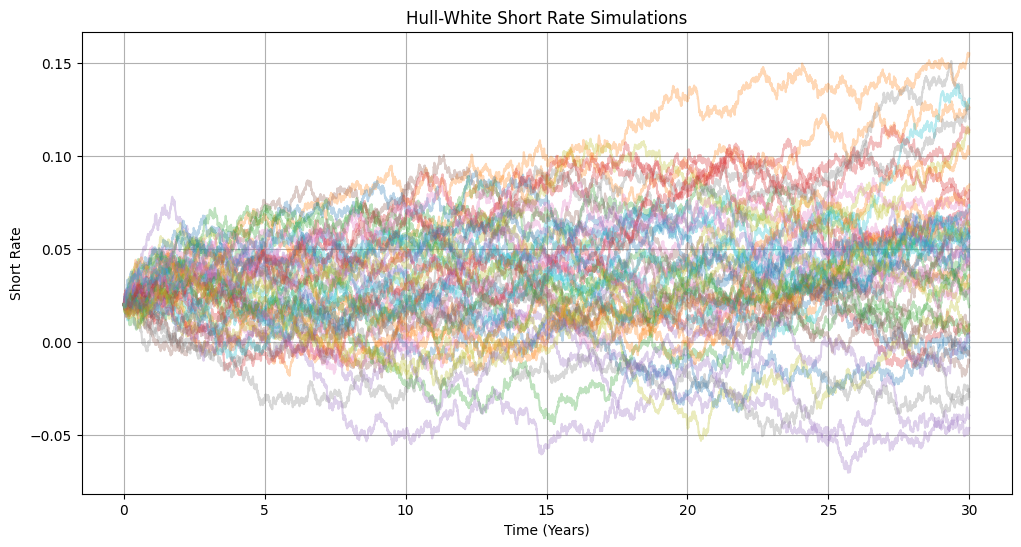

In [18]:
def simulate_hw_paths(r0, kappa, sigma, theta_func, T, dt, n_paths):
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps + 1))
    times = np.linspace(0, T, n_steps + 1)
    rates[:, 0] = r0
    for i in range(1, n_steps + 1):
        t = times[i-1]
        dW = np.random.normal(0.0, np.sqrt(dt), size=n_paths)
        theta_t = theta_func(t)
        rates[:, i] = rates[:, i-1] + (theta_t - kappa * rates[:, i-1]) * dt + sigma * dW
    return times, rates

T = 30
dt = 1/252
n_paths = 100
r0 = 0.02
theta_func = make_theta(calibrated_kappa, calibrated_sigma)
times, sim_rates = simulate_hw_paths(r0, calibrated_kappa, calibrated_sigma, theta_func, T, dt, n_paths)

# Plot paths
plt.figure(figsize=(12, 6))
for i in range(min(n_paths, 50)):
    plt.plot(times, sim_rates[i], alpha=0.3)
plt.title("Hull-White Short Rate Simulations")
plt.xlabel("Time (Years)")
plt.ylabel("Short Rate")
plt.grid(True)
plt.show()

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, root_scalar
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')